# Baseline melody perceptron experiments

Experiments with very simple model, exploring the effect of voicing on training results

## Training

In [1]:
# for automatic reloading of my libraries
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np

import datasets
from model import NetworkMelody

import common

In [3]:
train_data, test_data, small_test_data = common.prepare_medley()

....................
....................
....................
.......
...............


In [4]:
def create_model(self, args):
    # Get the melody annotation
    annotations = self.annotations[:, :, 0]
    
    audio_net = tf.layers.dense(self.window, 1024, activation=tf.nn.relu)
    output_layer = tf.layers.dense(audio_net, self.note_range, activation=None)

    self.note_probabilites = tf.reshape(output_layer, [-1, self.annotations_per_window, self.note_range])
    self.est_notes = tf.argmax(self.note_probabilites, axis=2)
    
    self.loss = tf.losses.sparse_softmax_cross_entropy(annotations, self.note_probabilites)
    
    global_step = tf.train.create_global_step()
    self.training = tf.train.AdamOptimizer().minimize(self.loss, global_step=global_step)

    print("total parameter count:", np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]))

In [5]:
args = {
    "threads": 6,
    "batch_size": 32,
    "annotations_per_window": 1,
    "frame_width": round(256/(44100/16000)), # frame_width of MedleyDB resampled to 16000 Hz
    "context_width": 944,
    "note_range": 128,
    "samplerate": 16000
}

name = common.name(args)
print(name)

# To restore model from a checkpoint
# args["logdir"] = "..."

# Construct the network
network = NetworkMelody(threads=args["threads"])

with network.session.graph.as_default():
    sess = network.session
    
    preload_hook = lambda aa: aa.audio.load_resampled_audio(args["samplerate"])
    dataset_transform = lambda dataset: dataset.batch(128).prefetch(1)
    dataset_transform_train = lambda dataset: dataset.shuffle(100000).batch(args["batch_size"]).prefetch(1)
    
    train_dataset = datasets.AADataset(train_data, args, preload_hook, dataset_transform_train)
    test_dataset = datasets.AADataset(test_data, args, preload_hook, dataset_transform)
    small_test_dataset = datasets.AADataset(small_test_data, args, preload_hook, dataset_transform)

    network.construct(args, create_model, test_dataset.dataset.output_types, test_dataset.dataset.output_shapes, dataset_preload_hook=preload_hook, dataset_transform=dataset_transform)

-01-21_170906-bs32-apw1-fw93-ctx944-nr128-sr16000
total parameter count: 2160768


In [6]:
epochs = 1
network.train(train_dataset, test_dataset, small_test_dataset, epochs, eval_small_every_n_batches=1000, eval_every_n_batches=10000, save_every_n_batches=60000)

=== epoch 1 ===
.....b 1000; t 27.91; acc 1.00; loss 2.09


/home/jirka/.local/lib/python3.7/site-packages/mir_eval/melody.py:231: UserWarning: Non-uniform timescale passed to resample_melody_series.  Pitch will be linearly interpolated, which will result in undesirable behavior if silences are indicated by missing values.  Silences should be indicated by nonpositive frequency values.
  "Non-uniform timescale passed to resample_melody_series.  Pitch "
/home/jirka/.local/lib/python3.7/site-packages/mir_eval/melody.py:79: UserWarning: Estimated melody has no voiced frames.
  warnings.warn("Estimated melody has no voiced frames.")


small_validation: t 0.53, OA: 0.22, RPA: 0.05, VR: 0.31
.....b 2000; t 14.22; acc 1.00; loss 1.73
small_validation: t 0.49, OA: 0.20, RPA: 0.02, VR: 0.38
.....b 3000; t 14.29; acc 1.00; loss 1.71
small_validation: t 0.49, OA: 0.20, RPA: 0.01, VR: 0.37
.....b 4000; t 14.28; acc 1.00; loss 1.94
small_validation: t 0.49, OA: 0.19, RPA: 0.01, VR: 0.45
.....b 5000; t 14.37; acc 1.00; loss 1.90
small_validation: t 0.49, OA: 0.20, RPA: 0.00, VR: 0.40
.....b 6000; t 14.25; acc 1.00; loss 1.64
small_validation: t 0.48, OA: 0.24, RPA: 0.00, VR: 0.26
.....b 7000; t 13.86; acc 1.00; loss 0.85
small_validation: t 0.51, OA: 0.24, RPA: 0.00, VR: 0.26
.....b 8000; t 13.34; acc 1.00; loss 1.91
small_validation: t 0.52, OA: 0.25, RPA: 0.00, VR: 0.21
.....b 9000; t 13.37; acc 1.00; loss 1.75
small_validation: t 0.84, OA: 0.25, RPA: 0.01, VR: 0.27
.....b 10000; t 13.60; acc 1.00; loss 2.52
small_validation: t 0.58, OA: 0.26, RPA: 0.00, VR: 0.21
validation: t 83.48, OA: 0.44, RPA: 0.23, VR: 0.55
.....b 110

In [8]:
network.save()

Model saved in path: models/perceptron-01-20_185610-bs32-apw1-fw93-ctx944-nr128-sr16000/model.ckpt


## Evaluation


Small testing dataset metrics:
Voicing Recall         0.113653
Voicing False Alarm    0.118425
Raw Pitch Accuracy     0.004160
Raw Chroma Accuracy    0.036990
Overall Accuracy       0.161792
dtype: float64


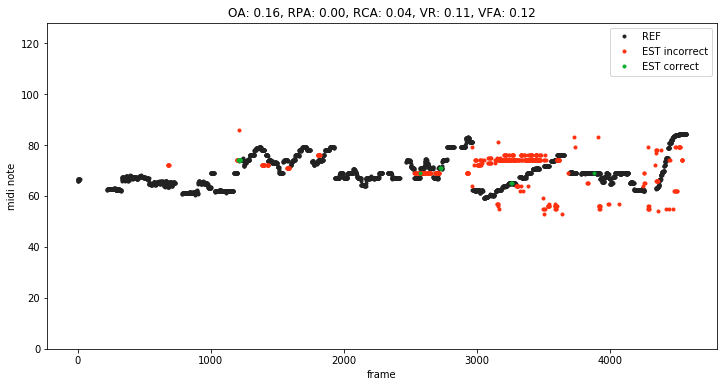

In [10]:
print("\nSmall testing dataset metrics:")
acc = network.evaluate(small_test_dataset, visual_output=True, print_detailed=True)

In [7]:
# Orchset evaluation
print("ORCHSET evaluation")
test_data_orchset = datasets.orchset.dataset("data/Orchset/")
orchset_dataset = datasets.AADataset(test_data_orchset, args, preload_hook, dataset_transform)
network.evaluate(orchset_dataset, print_detailed=True)

#print("ADC04 evaluation")
#test_data_adc04 = datasets.adc2004.dataset("datasets/adc2004/")
#datasets.load_all(test_data_adc04, 16000)
#adc04_dataset = datasets.AADataset(test_data_adc04, annotations_per_window, context_width, shuffle_batches=False)
#acc = network.evaluate(adc04_dataset, args["batch_size"], print_detailed=True)

ORCHSET evaluation
....................
....................
....................
....
Voicing Recall         0.199410
Voicing False Alarm    0.116450
Raw Pitch Accuracy     0.059273
Raw Chroma Accuracy    0.186437
Overall Accuracy       0.112847
dtype: float64


(0.11284666894377601, 0.05927312329344167, 0.19941044893443394)

In [ ]:
import evaluation
evaluation.evaluate_model(network, "evaluation_test10")

In [ ]:
import visualization as vis
# play the small testing dataset
vis.samplesplayer(small_test_dataset.all_samples(), small_test_dataset.samplerate)